In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import seaborn as sns

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

from sklearn.model_selection import train_test_split

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 12

# inputs: M, R, Fe/Mg, Si/Mg

In [2]:
input_parameters = [
    'Mass', 
    'Radius',
    'FeMg',
    'SiMg',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF', 
    'CPS',
    'CTP',
    'k2'
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "MRFeMgSi_20230712-9.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("Xscaler_20230711.save")
output_scaler = joblib.load("yscaler_20230711.save")


# Predict Kepler-78b

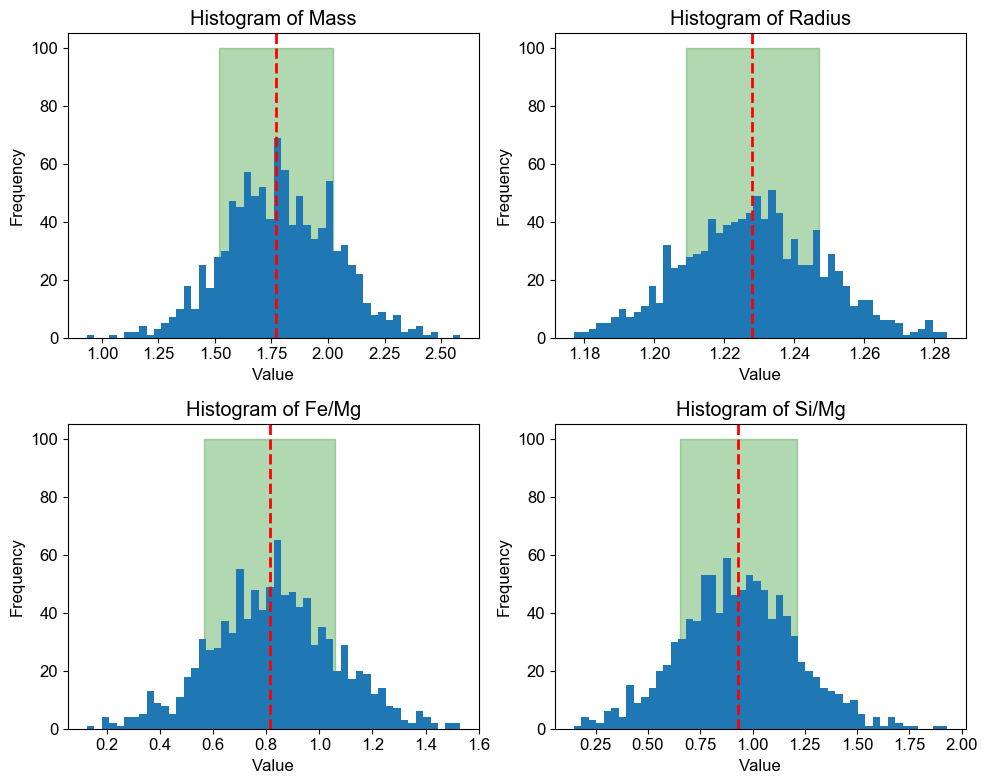

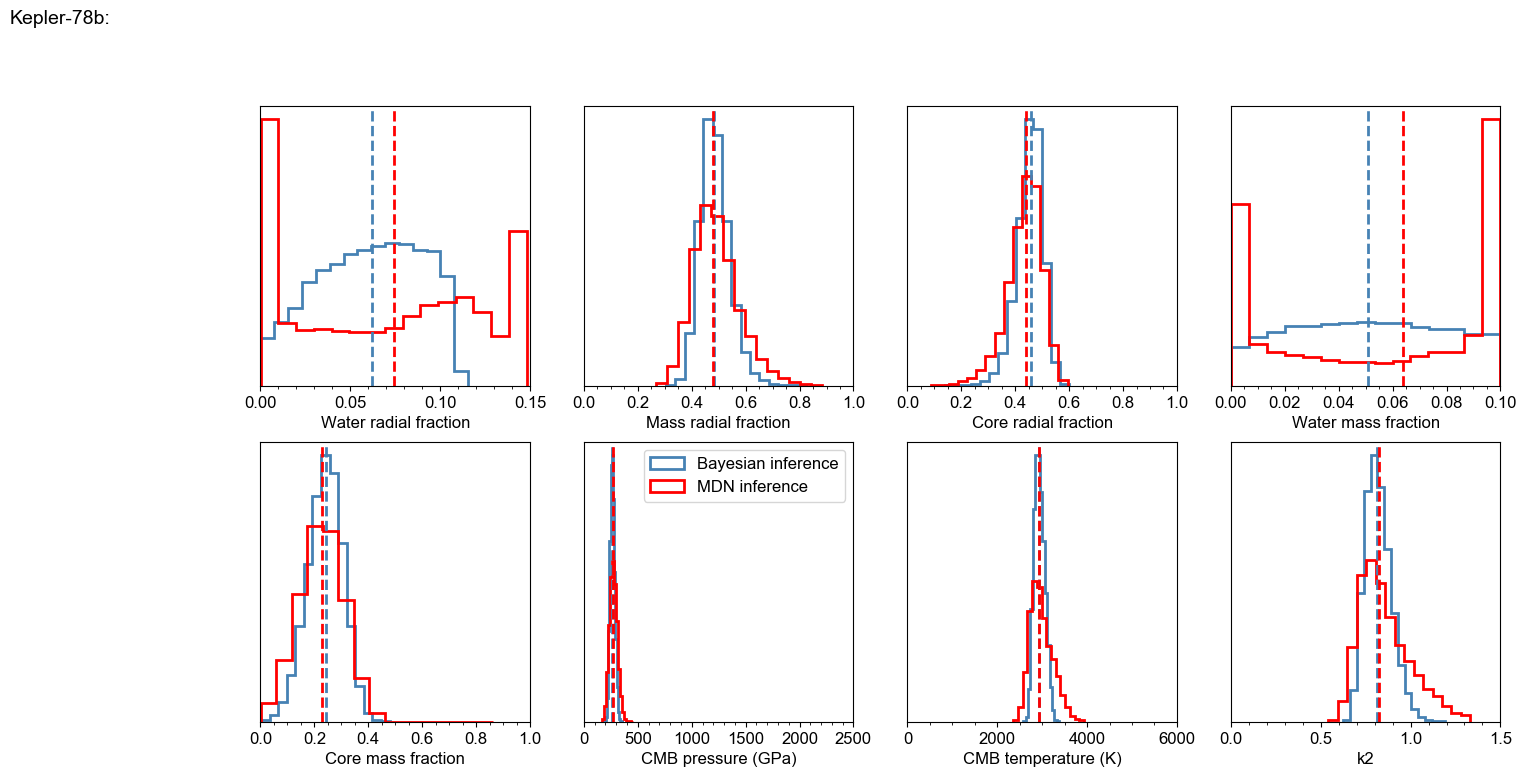

In [7]:
## Generate samples

# 设置随机数种子以便重复实验
np.random.seed(125)

# 从kepler 78b的均值和误差范围中生成1000个随机样本
mass_mean = 1.77
mass_err = 0.25
mass_samples = np.random.normal(loc=mass_mean, scale=mass_err, size=1000)

radius_mean = 1.228
radius_err = 0.019
radius_samples = np.random.normal(loc=radius_mean, scale=radius_err, size=1000)

femg_mean = 0.813
femg_err = 0.248
femg_samples = np.random.normal(loc=femg_mean, scale=femg_err, size=1000)

simg_mean = 0.933
simg_err = 0.281
simg_samples = np.random.normal(loc=simg_mean, scale=simg_err, size=1000)

# 将所有样本整合成一个输入矩阵
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# 创建一个2x2的子图画布
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 循环绘制每个子图中的直方图并标出均值和误差范围
for i, ax in enumerate(axs.flat):
    if i == 0:
        samples = mass_samples
        mean = mass_mean
        err = mass_err
        title = 'Histogram of Mass'
    elif i == 1:
        samples = radius_samples
        mean = radius_mean
        err = radius_err
        title = 'Histogram of Radius'
    elif i == 2:
        samples = femg_samples
        mean = femg_mean
        err = femg_err
        title = 'Histogram of Fe/Mg'
    else:
        samples = simg_samples
        mean = simg_mean
        err = simg_err
        title = 'Histogram of Si/Mg'

    ax.hist(samples, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # 标出均值的竖直线
    ax.fill_between([mean-err, mean+err], [0,0], [100,100], alpha=0.3, color='green')  # 标出误差范围的区域

# 调整子图之间的距离和边界
plt.tight_layout()
# plt.savefig('gaussian_hist.pdf')
# 显示图表
plt.show()

## 叠加pdf

## Gaussian Sampling

input_list = X
density_x = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
density_y = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
prop_density = [0, 0, 0, 0, 0, 0, 0, 0]  # 存储wrf,mrf,crf,cmf,cmb_t,cmb_p所有样本的概率分布加和
for input_array in input_list:
    scaled_input = input_scaler.transform([input_array])
#     print(1)
#     print(scaled_input)
    pred = model.predict(scaled_input)
    mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
    sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
    pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
    
    for m in range(OUTPUT_DIMS):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
    #     print(m)
        for n in range(N_MIXES):
    #         print(n)
            locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
            locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])
    y_label = np.arange(0,1,0.001).reshape(-1,1)
#     print(y_label)
    for i, output_param in enumerate(output_parameters):
#         ax = fig.add_subplot(3, 2, i+1)
        # y_label = y_labels[:, i].reshape(-1,1)
        # for i, label in zip(range(OUTPUT_DIMS), predict_label):
    #     fig, ax = plt.subplots(figsize=(8,4))
        # label = "Water radial fraction"
        ###################Earth###########################
        mus_ = np.array(locals()['mus'+str(i)])
#         print(mus_)
        sigs_ = np.array(locals()['sigs'+str(i)])
#         print(sigs_)
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
#         print(i)
#         print(GMM_PDF)
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
            size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=size, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])



## MCMC vs MDN

x_max = [0.15,1, 1, 0.1, 1, 2500, 6000,1.5]
x_locator = [
    0.05,
    0.2,
    0.2,
    0.02,
    0.2,
    500,
    2000,
    0.5
]
colors = [
    "steelblue",
    "steelblue",
    "steelblue", 
    "steelblue", 
    "steelblue",
    "steelblue",
    "steelblue",
    "steelblue"
]
predict_label = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF', 
    'CPS',
    'CTP',
    'k2'
]


################# read mcmc results###############
file_path = "mcmc_results/kepler78b_feo.csv"
df_k = pd.read_csv(file_path, 
#                    sep='\t'
                  )
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

################# transform mdn results to original data ###############
df_x = pd.DataFrame.from_dict(density_x)
original_x = output_scaler.inverse_transform(df_x)

################ plot histagram for predictions of MDN and MCMC ###################
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(
#     hspace=0.7, 
#     wspace=0.2
)
for i, output_param in enumerate(output_parameters):
    ax = fig.add_subplot(2, 4, i+1)
    
    # plot MCMC results
    x = df_k[output_param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='Bayesian inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)
#     label = f'Median: {median:.2f}'
#     ax.text(median, np.max(counts) / 2, label, ha='left', va='center', color='r', fontsize=12)
    
#     q16, q84 = np.percentile(params_x, [16, 84])
#     err_line = Line2D([q16, q84], [0.9 * np.max(hist), 0.9 * np.max(hist)], color='m', linewidth=2)
#     ax.add_line(err_line)
    
    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
    if i ==5:
        ax.legend()
fig.suptitle('Kepler-78b:', x=0, y=1, fontsize=14)
# fig.legend(["MCMC", "MDN"], loc='upper left', ncol=2)
# plt.tight_layout()
plt.savefig('Kepler78b.pdf')

df_k_p = df_k[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# 将结果写入Excel文件
# df_results.to_excel("Kepler78b_err.xlsx", index=False)

In [4]:
df_mdn_samples = pd.DataFrame(data=original_x,columns=output_parameters)

In [5]:
df_mdn_samples

,WRF,MRF,CRF,WMF,CMF,CPS,CTP,k2
0,0.144870,0.330812,0.484753,0.0983,0.393526,224.988958,2654.280136,0.621885
1,0.147094,0.331622,0.489478,0.0986,0.321049,237.959917,2665.665304,0.647301
2,0.143980,0.355095,0.509167,0.0996,0.378858,215.723987,2548.018561,0.653655
3,0.144722,0.351048,0.527281,0.0997,0.334854,234.253929,2597.354292,0.661597
4,0.148132,0.382615,0.491841,0.0992,0.376270,217.576981,2658.075192,0.652066
...,...,...,...,...,...,...,...,...
19995,0.103056,0.581732,0.416234,0.0980,0.134677,280.578783,2802.287329,0.830772
19996,0.105280,0.583351,0.334327,0.0995,0.147619,239.812912,2851.623060,0.875250
19997,0.111508,0.572019,0.402058,0.0968,0.127774,247.224888,2768.131823,0.775969
19998,0.117587,0.541261,0.346928,0.0971,0.091535,241.665906,2809.877442,0.818859


In [6]:
df_mdn_samples.describe()

,WRF,MRF,CRF,WMF,CMF,CPS,CTP,k2
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.070014,0.491757,0.433327,0.055272,0.224661,275.107540,2980.033152,0.856020
std,0.050733,0.086167,0.065373,0.039283,0.082481,36.680632,252.518436,0.143325
min,0.000152,0.268487,0.086243,0.000101,0.001801,169.399133,2358.265749,0.542460
25%,0.017352,0.431990,0.396545,0.011401,0.168327,249.077882,2794.697217,0.748965
50%,0.074142,0.480555,0.441436,0.063800,0.226568,273.166807,2938.909354,0.825213
75%,0.114177,0.541261,0.479240,0.096400,0.282221,299.108725,3140.047335,0.939584
max,0.148132,0.882835,0.594225,0.099900,0.862907,451.054248,3929.419033,1.332738


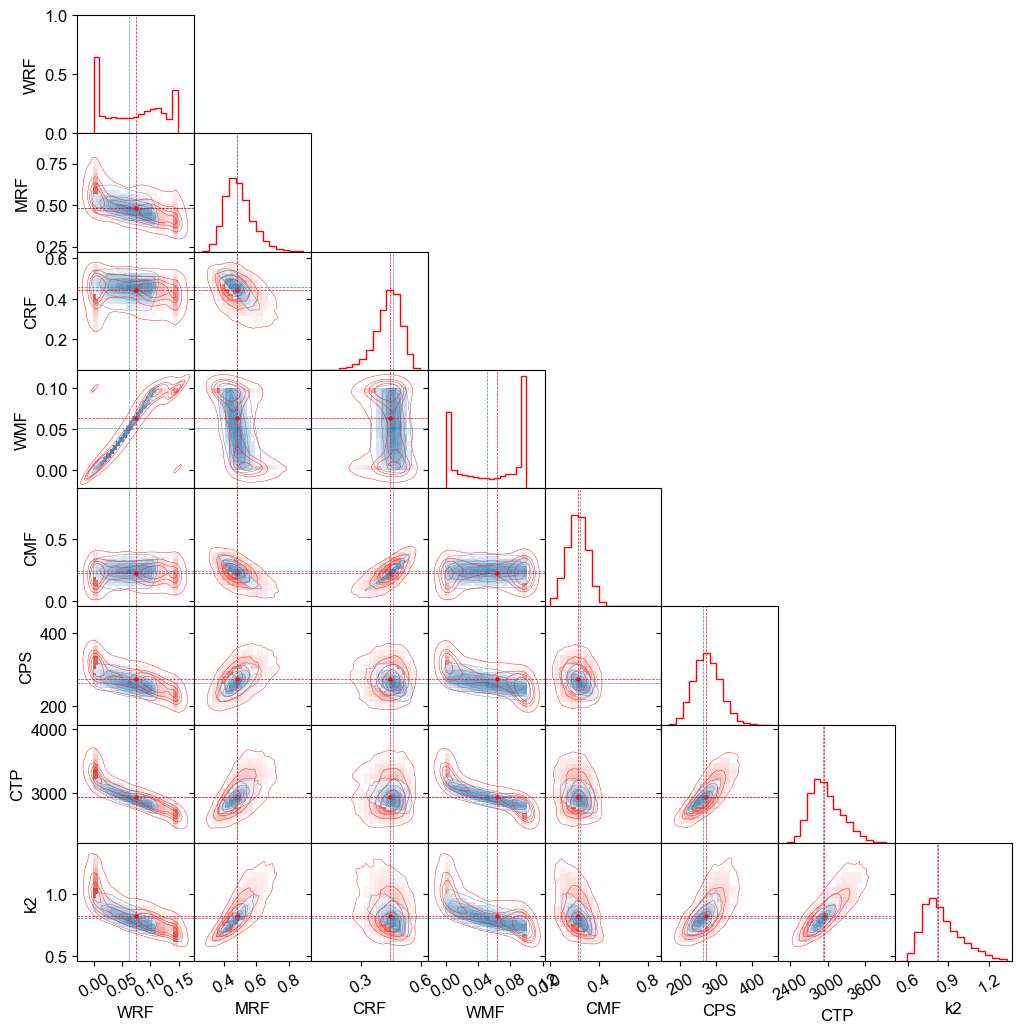

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# 获取hsv cmap
cmap = cm.hsv

# 将cmap分割为8种颜色  
colors = cmap(np.linspace(0, 1, 8))
end_color = (242, 77, 59)
start_color = (255, 255, 255) # 白色
c = np.array([tuple(color/255) for color in np.linspace(start_color, end_color, 256)])
custom_cmap = ListedColormap(c)



g = sns.PairGrid(df_mdn_samples, despine=True)
# g = sns.PairGrid(df_k[output_parameters])
g.fig.set_size_inches(10,10)
# g.map_diag(sns.histplot, color='#9f3fa0', bins=15, element='step', fill=False)
# g.map_diag(plt.hist, color='#9f3fa0', bins=15, density=False, histtype='step', fill=False)
g.map_diag(plt.hist, color='r', bins=15, density=False, histtype='step', fill=False)
# g.map_diag(sns.histplot, color='#94c4df', bins=15, 
#            stat="density", 
#            element="step", fill=False)
# g.map_upper(sns.scatterplot, color='#98d593', alpha=0.4,s=2)
g.map_lower(sns.histplot, bins=20, pthresh=.1, cmap=custom_cmap)
g.map_lower(sns.kdeplot, levels=5, color="r", linewidths=0.3)




median_values = df_mdn_samples.median().values
mc_median_values = df_k[output_parameters].median().values


from matplotlib.ticker import MultipleLocator

x_locator = [
    MultipleLocator(0.05), 
    MultipleLocator(0.2),
    MultipleLocator(0.3),
    MultipleLocator(0.04),
    MultipleLocator(0.4),
    MultipleLocator(100),
    MultipleLocator(600),
    MultipleLocator(0.3),
]

g.data = df_k[output_parameters]

g.map_diag(plt.hist, color='#4682b4', bins=15, 
           density=False, 
           histtype='step', fill=False)

# 获取hsv cmap
cmap = cm.hsv
# 将cmap分割为8种颜色  
colors = cmap(np.linspace(0, 1, 8))
end_color = (92, 144, 189)
start_color = (255, 255, 255) # 白色
c = np.array([tuple(color/255) for color in np.linspace(start_color, end_color, 256)])
custom_cmap = ListedColormap(c)
g.map_lower(sns.histplot, bins=20, pthresh=.1, cmap=custom_cmap)
g.map_lower(sns.kdeplot, levels=5, color="#4682b4", linewidths=0.3)
    
for i in range(8):
    for j in range(8):
        
        if i < j:
            g.axes[i,j].set_axis_off()
#             g.axes[i,j].yaxis.set_major_locator(x_locator[i])
#             pass
        elif i==j:
            
            g.axes[i,j].xaxis.set_major_locator(x_locator[i])
#             sns.histplot(df_k[output_parameters[i]], color='#9f3fa0', bins=15, element='step', fill=False, ax=g.axes[i,j])
            g.axes[i,j].axvline(median_values[i], color='r', lw=0.5, ls='--')
            g.axes[i,j].axvline(mc_median_values[i], color='#4682b4', ls='--',  lw=0.5)
        else:
#             pass
            g.axes[i,j].axvline(median_values[j], color='r', zorder=10, lw=0.5, ls='--')
            g.axes[i,j].axhline(median_values[i], color='r', zorder=10, lw=0.5, ls='--')
            g.axes[i,j].scatter(median_values[j], median_values[i], color='r', s=5)
            
            
#             g.axes[i,j].yaxis.set_major_locator(x_locator[i])
            g.axes[i,j].axvline(mc_median_values[j], color='#4682b4', ls='--',  lw=0.5)
            g.axes[i,j].axhline(mc_median_values[i], color='#4682b4', ls='--',  lw=0.5)
            g.axes[i,j].scatter(mc_median_values[j], mc_median_values[i], color='#4682b4', s=5, marker='o')

g.fig.subplots_adjust(wspace=0, hspace=0)
for i,ax in enumerate(g.axes.flatten()):
#     if i in range(8,8*8,8):
#         print(i)
#         ax.yaxis.set_major_locator(x_locator[int(i/8)])
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True) 
    ax.xaxis.set_tick_params(rotation=30)

# plt.tight_layout()
plt.savefig("kepler78b_MC_MDN_r.pdf",bbox_inches = 'tight')

# Predict HD3167b

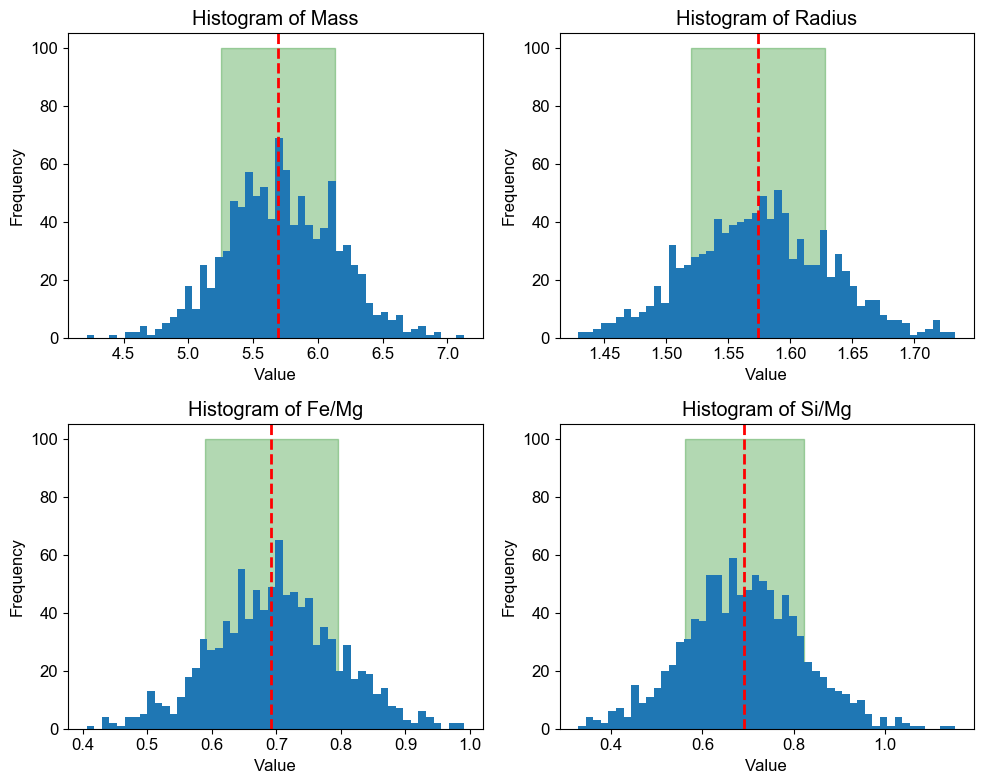

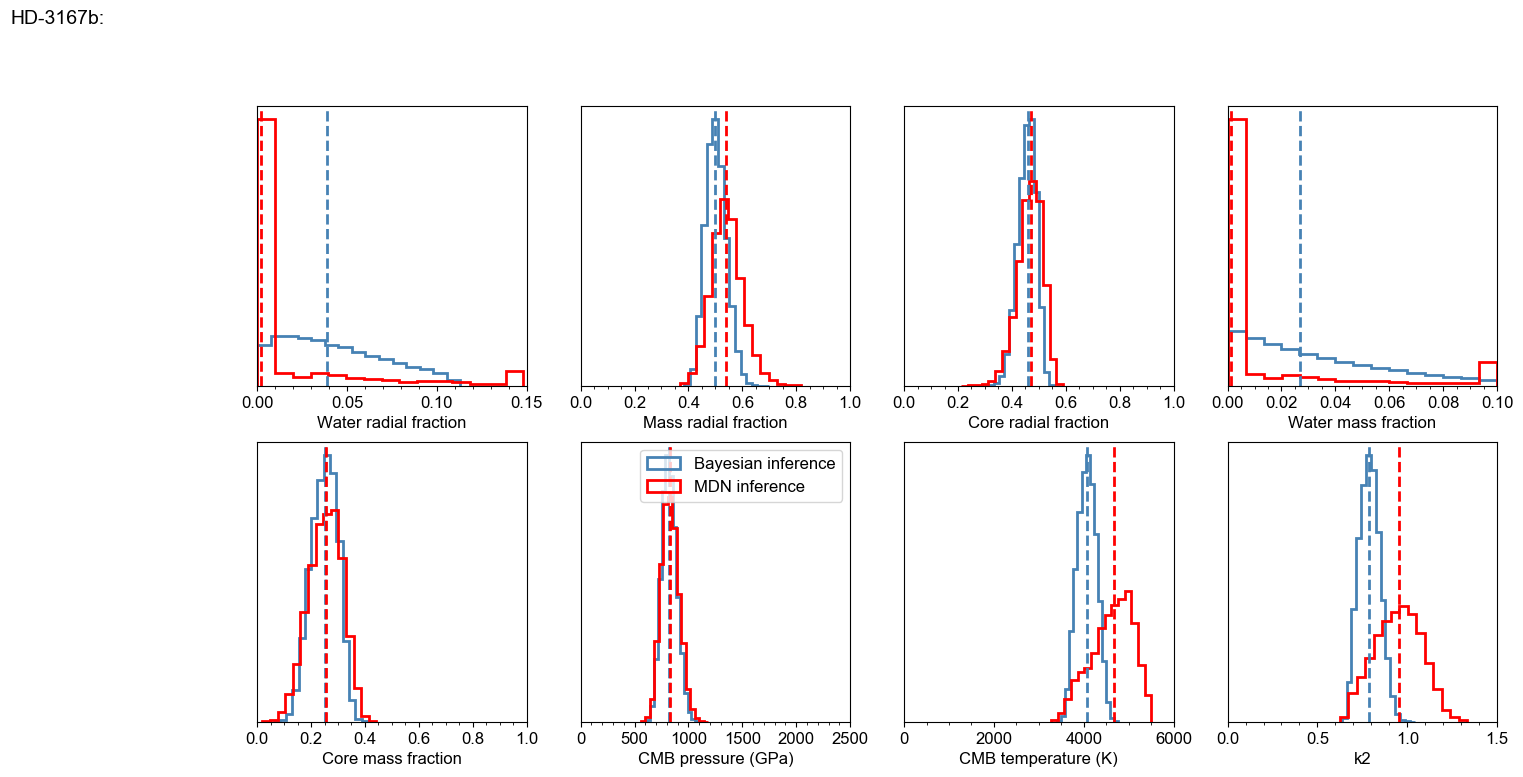

In [15]:
## Generate samples

# 设置随机数种子以便重复实验
np.random.seed(125)

# 从kepler 78b的均值和误差范围中生成1000个随机样本
mass_mean = 5.69
mass_err = 0.44
mass_samples = np.random.normal(loc=mass_mean, scale=mass_err, size=1000)

radius_mean = 1.574
radius_err = 0.054
radius_samples = np.random.normal(loc=radius_mean, scale=radius_err, size=1000)

femg_mean = 0.692
femg_err = 0.103
femg_samples = np.random.normal(loc=femg_mean, scale=femg_err, size=1000)

simg_mean = 0.692
simg_err = 0.13
simg_samples = np.random.normal(loc=simg_mean, scale=simg_err, size=1000)

# 将所有样本整合成一个输入矩阵
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# 创建一个2x2的子图画布
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 循环绘制每个子图中的直方图并标出均值和误差范围
for i, ax in enumerate(axs.flat):
    if i == 0:
        samples = mass_samples
        mean = mass_mean
        err = mass_err
        title = 'Histogram of Mass'
    elif i == 1:
        samples = radius_samples
        mean = radius_mean
        err = radius_err
        title = 'Histogram of Radius'
    elif i == 2:
        samples = femg_samples
        mean = femg_mean
        err = femg_err
        title = 'Histogram of Fe/Mg'
    else:
        samples = simg_samples
        mean = simg_mean
        err = simg_err
        title = 'Histogram of Si/Mg'

    ax.hist(samples, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # 标出均值的竖直线
    ax.fill_between([mean-err, mean+err], [0,0], [100,100], alpha=0.3, color='green')  # 标出误差范围的区域

# 调整子图之间的距离和边界
plt.tight_layout()
plt.savefig('HD3167b_gaussian_hist.pdf')
# 显示图表
plt.show()

## Gaussian Sampling

input_list = X
density_x = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
density_y = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
prop_density = [0, 0, 0, 0, 0, 0, 0, 0]  # 存储wrf,mrf,crf,cmf,cmb_t,cmb_p所有样本的概率分布加和
for input_array in input_list:
    scaled_input = input_scaler.transform([input_array])
#     print(1)
#     print(scaled_input)
    pred = model.predict(scaled_input)
    mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
    sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
    pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
    
    for m in range(OUTPUT_DIMS):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
    #     print(m)
        for n in range(N_MIXES):
    #         print(n)
            locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
            locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])
    y_label = np.arange(0,1,0.001).reshape(-1,1)
#     print(y_label)
    for i, output_param in enumerate(output_parameters):
#         ax = fig.add_subplot(3, 2, i+1)
        # y_label = y_labels[:, i].reshape(-1,1)
        # for i, label in zip(range(OUTPUT_DIMS), predict_label):
    #     fig, ax = plt.subplots(figsize=(8,4))
        # label = "Water radial fraction"
        ###################Earth###########################
        mus_ = np.array(locals()['mus'+str(i)])
#         print(mus_)
        sigs_ = np.array(locals()['sigs'+str(i)])
#         print(sigs_)
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
#         print(i)
#         print(GMM_PDF)
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
            size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=size, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])



## MCMC vs MDN

x_max = [0.15,1, 1, 0.1, 1, 2500, 6000,1.5]
x_locator = [
    0.05,
    0.2,
    0.2,
    0.02,
    0.2,
    500,
    2000,
    0.5
]
colors = [
    "steelblue",
    "steelblue",
    "steelblue", 
    "steelblue", 
    "steelblue",
    "steelblue",
    "steelblue",
    "steelblue"
]

predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]

################# read mcmc results###############
file_path = "mcmc_results/HD3167b_feo.csv"
df_k = pd.read_csv(file_path, 
#                    sep='\t'
                  )
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

################# transform mdn results to original data ###############
df_x = pd.DataFrame.from_dict(density_x)
original_x = output_scaler.inverse_transform(df_x)

################ plot histagram for predictions of MDN and MCMC ###################
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(
#     hspace=0.7, 
#     wspace=0.2
)
for i, output_param in enumerate(output_parameters):
    ax = fig.add_subplot(2, 4, i+1)
    
    # plot MCMC results
    x = df_k[output_param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='Bayesian inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)
#     label = f'Median: {median:.2f}'
#     ax.text(median, np.max(counts) / 2, label, ha='left', va='center', color='r', fontsize=12)
    
#     q16, q84 = np.percentile(params_x, [16, 84])
#     err_line = Line2D([q16, q84], [0.9 * np.max(hist), 0.9 * np.max(hist)], color='m', linewidth=2)
#     ax.add_line(err_line)
    
    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
    if i ==5:
        ax.legend()
fig.suptitle('HD-3167b:', x=0, y=1, fontsize=14)
# fig.legend(["MCMC", "MDN"], loc='upper left', ncol=2)
# plt.tight_layout()
plt.savefig('HD3167b.pdf')

df_k_p = df_k[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# 将结果写入Excel文件
# df_results.to_excel("HD3167b_err.xlsx", index=False)

# Kepler10b
#### Mass = 3.72 ± 0.42
#### Radius = 1.47 ± 0.03
#### Fe/Mg = 0.589 ± 0.073
#### Si/Mg = 0.661 ± 0.098

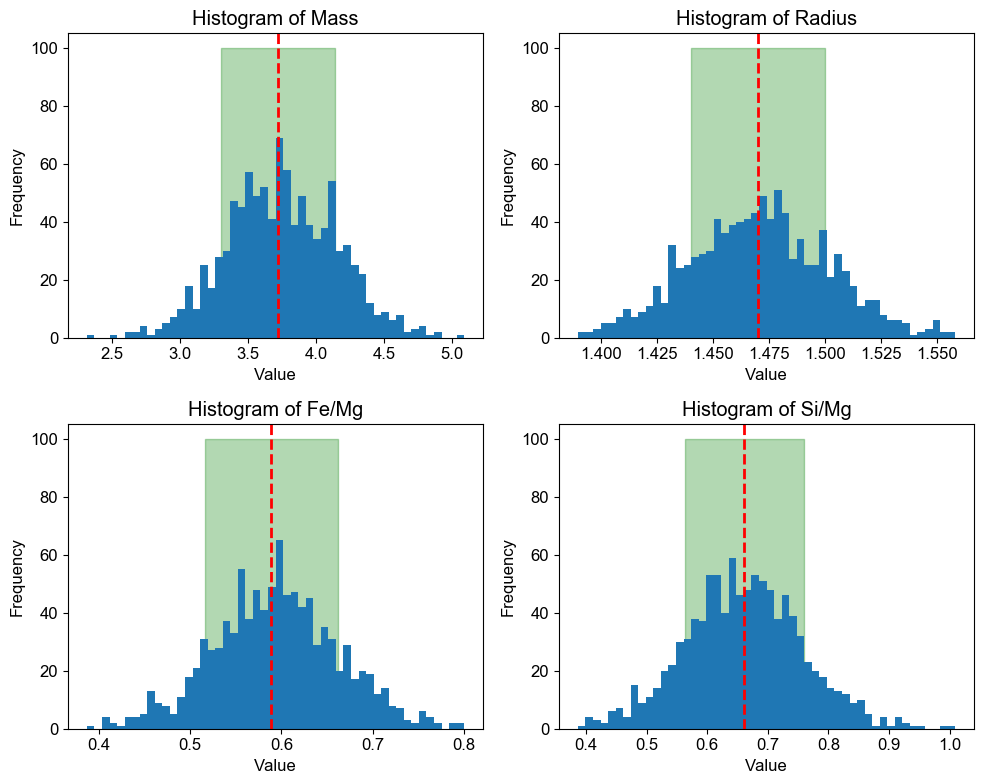

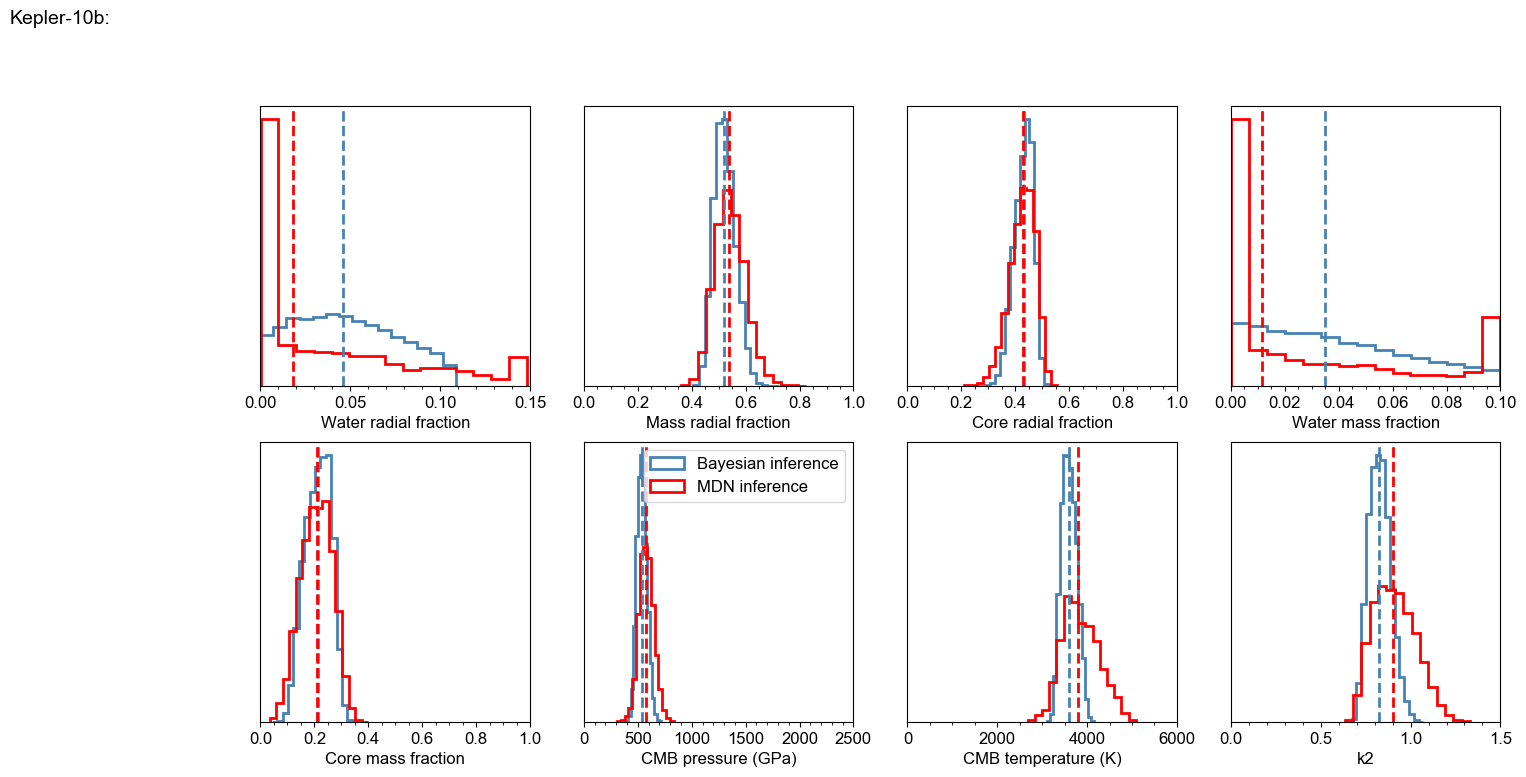

In [16]:
## Generate samples

# 设置随机数种子以便重复实验
np.random.seed(125)

# 从kepler 78b的均值和误差范围中生成1000个随机样本
mass_mean = 3.72
mass_err = 0.42
mass_samples = np.random.normal(loc=mass_mean, scale=mass_err, size=1000)

radius_mean = 1.47
radius_err = 0.03
radius_samples = np.random.normal(loc=radius_mean, scale=radius_err, size=1000)

femg_mean = 0.589
femg_err = 0.073
femg_samples = np.random.normal(loc=femg_mean, scale=femg_err, size=1000)

simg_mean = 0.661
simg_err = 0.098
simg_samples = np.random.normal(loc=simg_mean, scale=simg_err, size=1000)

# 将所有样本整合成一个输入矩阵
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# 创建一个2x2的子图画布
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 循环绘制每个子图中的直方图并标出均值和误差范围
for i, ax in enumerate(axs.flat):
    if i == 0:
        samples = mass_samples
        mean = mass_mean
        err = mass_err
        title = 'Histogram of Mass'
    elif i == 1:
        samples = radius_samples
        mean = radius_mean
        err = radius_err
        title = 'Histogram of Radius'
    elif i == 2:
        samples = femg_samples
        mean = femg_mean
        err = femg_err
        title = 'Histogram of Fe/Mg'
    else:
        samples = simg_samples
        mean = simg_mean
        err = simg_err
        title = 'Histogram of Si/Mg'

    ax.hist(samples, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # 标出均值的竖直线
    ax.fill_between([mean-err, mean+err], [0,0], [100,100], alpha=0.3, color='green')  # 标出误差范围的区域

# 调整子图之间的距离和边界
plt.tight_layout()
plt.savefig('kepler10b_gaussian_hist.pdf')
# 显示图表
plt.show()

## 叠加pdf

## Gaussian Sampling

input_list = X
density_x = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
density_y = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
prop_density = [0, 0, 0, 0, 0, 0, 0, 0]  # 存储wrf,mrf,crf,cmf,cmb_t,cmb_p所有样本的概率分布加和
for input_array in input_list:
    scaled_input = input_scaler.transform([input_array])
#     print(1)
#     print(scaled_input)
    pred = model.predict(scaled_input)
    mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
    sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
    pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
    
    for m in range(OUTPUT_DIMS):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
    #     print(m)
        for n in range(N_MIXES):
    #         print(n)
            locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
            locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])
    y_label = np.arange(0,1,0.001).reshape(-1,1)
#     print(y_label)
    for i, output_param in enumerate(output_parameters):
#         ax = fig.add_subplot(3, 2, i+1)
        # y_label = y_labels[:, i].reshape(-1,1)
        # for i, label in zip(range(OUTPUT_DIMS), predict_label):
    #     fig, ax = plt.subplots(figsize=(8,4))
        # label = "Water radial fraction"
        ###################Earth###########################
        mus_ = np.array(locals()['mus'+str(i)])
#         print(mus_)
        sigs_ = np.array(locals()['sigs'+str(i)])
#         print(sigs_)
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
#         print(i)
#         print(GMM_PDF)
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
            size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=size, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])



## MCMC vs MDN

x_max = [0.15,1, 1, 0.1, 1, 2500, 6000,1.5]
x_locator = [
    0.05,
    0.2,
    0.2,
    0.02,
    0.2,
    500,
    2000,
    0.5
]
colors = [
    "steelblue",
    "steelblue",
    "steelblue", 
    "steelblue", 
    "steelblue",
    "steelblue",
    "steelblue",
    "steelblue"
]
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]


################# read mcmc results###############
file_path = "mcmc_results/Kepler10b_feo.csv"
df_k = pd.read_csv(file_path, 
#                    sep='\t'
                  )
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

################# transform mdn results to original data ###############
df_x = pd.DataFrame.from_dict(density_x)
original_x = output_scaler.inverse_transform(df_x)

################ plot histagram for predictions of MDN and MCMC ###################
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(
#     hspace=0.7, 
#     wspace=0.2
)
for i, output_param in enumerate(output_parameters):
    ax = fig.add_subplot(2, 4, i+1)
    
    # plot MCMC results
    x = df_k[output_param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='Bayesian inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)
#     label = f'Median: {median:.2f}'
#     ax.text(median, np.max(counts) / 2, label, ha='left', va='center', color='r', fontsize=12)
    
#     q16, q84 = np.percentile(params_x, [16, 84])
#     err_line = Line2D([q16, q84], [0.9 * np.max(hist), 0.9 * np.max(hist)], color='m', linewidth=2)
#     ax.add_line(err_line)
    
    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
    if i ==5:
        ax.legend()
fig.suptitle('Kepler-10b:', x=0, y=1, fontsize=14)
# fig.legend(["MCMC", "MDN"], loc='upper left', ncol=2)
# plt.tight_layout()
plt.savefig('Kepler10b.pdf')

df_k_p = df_k[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# 将结果写入Excel文件
# df_results.to_excel("Kepler10b_err.xlsx", index=False)

# HD219134b
#### Mass = 4.74 ± 0.19
#### Radius = 1.602 ± 0.055
#### Fe/Mg = 0.794 ± 0.154
#### Si/Mg = 0.871 ± 0.195

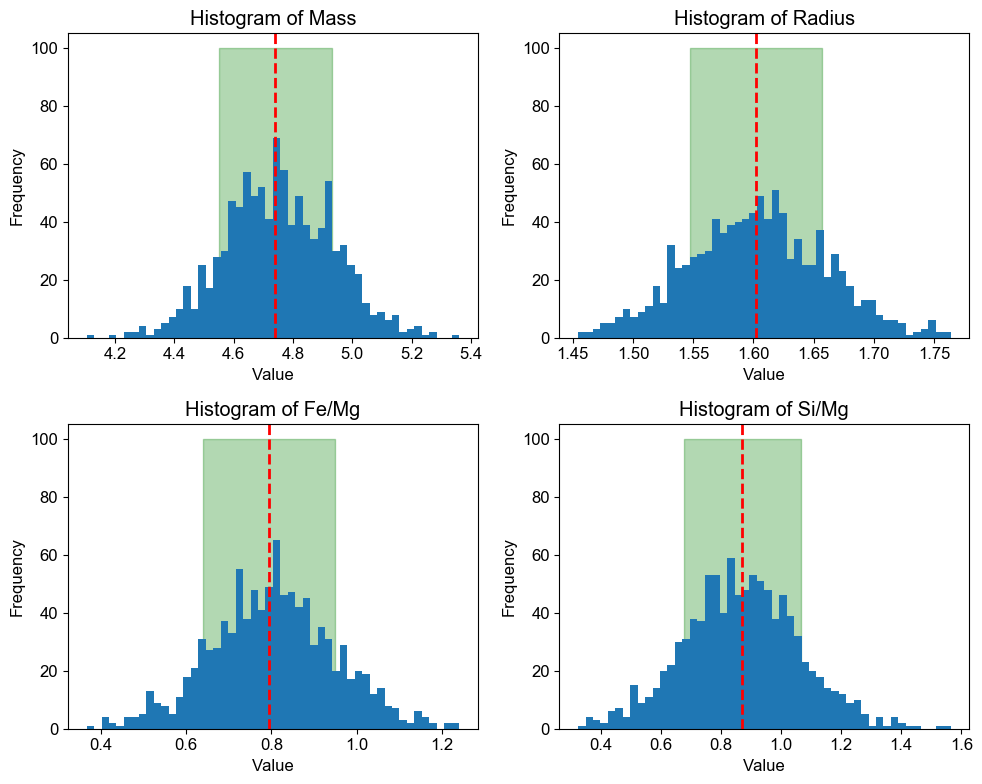

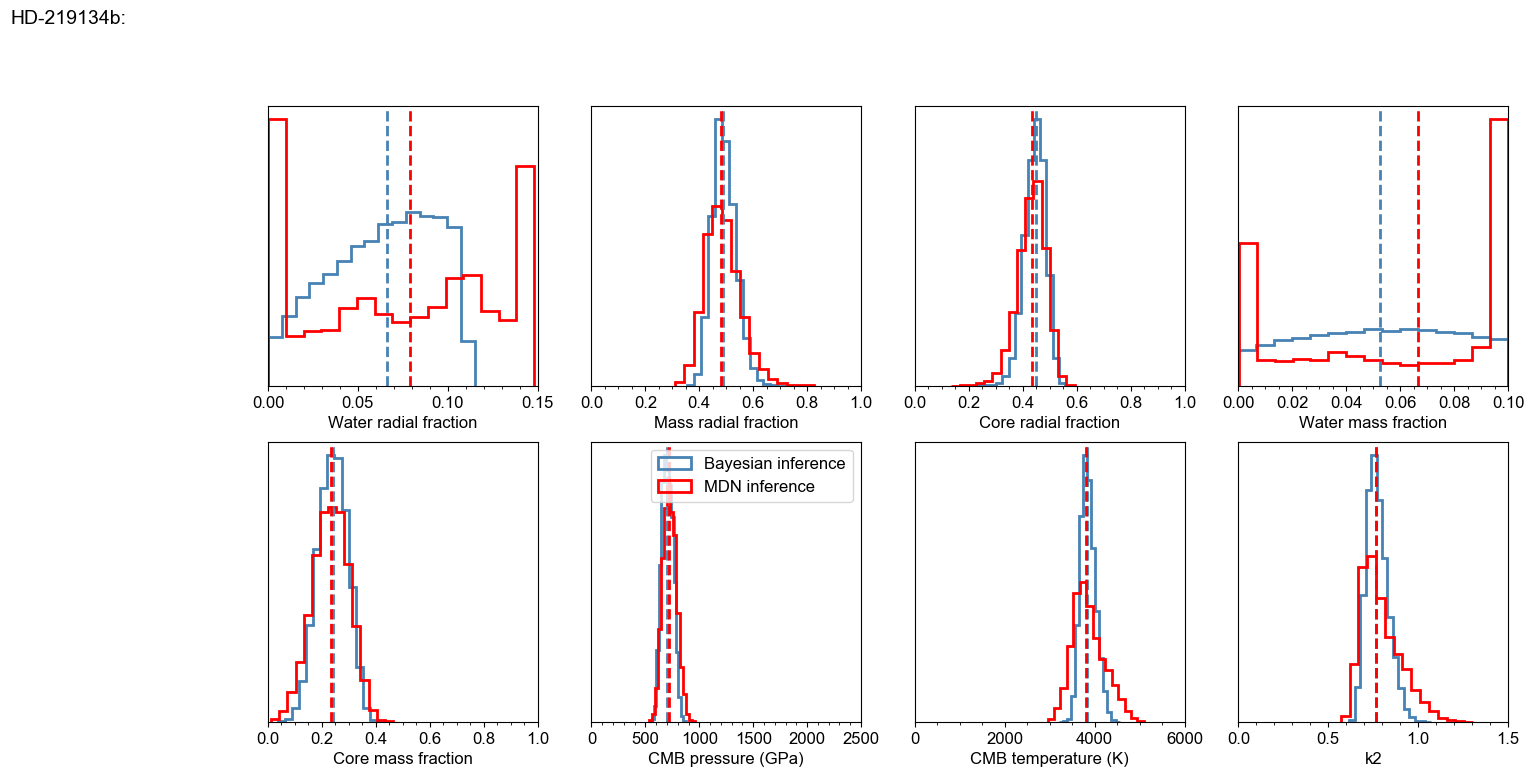

In [17]:
## Generate samples

# 设置随机数种子以便重复实验
np.random.seed(125)

# 从kepler 78b的均值和误差范围中生成1000个随机样本
mass_mean = 4.74
mass_err = 0.19
mass_samples = np.random.normal(loc=mass_mean, scale=mass_err, size=1000)

radius_mean = 1.602
radius_err = 0.055
radius_samples = np.random.normal(loc=radius_mean, scale=radius_err, size=1000)

femg_mean = 0.794
femg_err = 0.154
femg_samples = np.random.normal(loc=femg_mean, scale=femg_err, size=1000)

simg_mean = 0.871
simg_err = 0.195
simg_samples = np.random.normal(loc=simg_mean, scale=simg_err, size=1000)

# 将所有样本整合成一个输入矩阵
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# 创建一个2x2的子图画布
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 循环绘制每个子图中的直方图并标出均值和误差范围
for i, ax in enumerate(axs.flat):
    if i == 0:
        samples = mass_samples
        mean = mass_mean
        err = mass_err
        title = 'Histogram of Mass'
    elif i == 1:
        samples = radius_samples
        mean = radius_mean
        err = radius_err
        title = 'Histogram of Radius'
    elif i == 2:
        samples = femg_samples
        mean = femg_mean
        err = femg_err
        title = 'Histogram of Fe/Mg'
    else:
        samples = simg_samples
        mean = simg_mean
        err = simg_err
        title = 'Histogram of Si/Mg'

    ax.hist(samples, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # 标出均值的竖直线
    ax.fill_between([mean-err, mean+err], [0,0], [100,100], alpha=0.3, color='green')  # 标出误差范围的区域

# 调整子图之间的距离和边界
plt.tight_layout()
plt.savefig('HD219134b_gaussian_hist.pdf')
# 显示图表
plt.show()

## 叠加pdf

## Gaussian Sampling

input_list = X
density_x = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
density_y = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
prop_density = [0, 0, 0, 0, 0, 0, 0, 0]  # 存储wrf,mrf,crf,cmf,cmb_t,cmb_p所有样本的概率分布加和
for input_array in input_list:
    scaled_input = input_scaler.transform([input_array])
#     print(1)
#     print(scaled_input)
    pred = model.predict(scaled_input)
    mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
    sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
    pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
    
    for m in range(OUTPUT_DIMS):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
    #     print(m)
        for n in range(N_MIXES):
    #         print(n)
            locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
            locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])
    y_label = np.arange(0,1,0.001).reshape(-1,1)
#     print(y_label)
    for i, output_param in enumerate(output_parameters):
#         ax = fig.add_subplot(3, 2, i+1)
        # y_label = y_labels[:, i].reshape(-1,1)
        # for i, label in zip(range(OUTPUT_DIMS), predict_label):
    #     fig, ax = plt.subplots(figsize=(8,4))
        # label = "Water radial fraction"
        ###################Earth###########################
        mus_ = np.array(locals()['mus'+str(i)])
#         print(mus_)
        sigs_ = np.array(locals()['sigs'+str(i)])
#         print(sigs_)
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
#         print(i)
#         print(GMM_PDF)
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
            size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=size, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])



## MCMC vs MDN

x_max = [0.15,1, 1, 0.1, 1, 2500, 6000,1.5]
x_locator = [
    0.05,
    0.2,
    0.2,
    0.02,
    0.2,
    500,
    2000,
    0.5
]
colors = [
    "steelblue",
    "steelblue",
    "steelblue", 
    "steelblue", 
    "steelblue",
    "steelblue",
    "steelblue",
    "steelblue"
]

predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]

################# read mcmc results###############
file_path = "mcmc_results/HD219134b_feo.csv"
df_k = pd.read_csv(file_path, 
#                    sep='\t'
                  )
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

################# transform mdn results to original data ###############
df_x = pd.DataFrame.from_dict(density_x)
original_x = output_scaler.inverse_transform(df_x)

################ plot histagram for predictions of MDN and MCMC ###################
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(
#     hspace=0.7, 
#     wspace=0.2
)
for i, output_param in enumerate(output_parameters):
    ax = fig.add_subplot(2, 4, i+1)
    
    # plot MCMC results
    x = df_k[output_param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='Bayesian inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)
#     label = f'Median: {median:.2f}'
#     ax.text(median, np.max(counts) / 2, label, ha='left', va='center', color='r', fontsize=12)
    
#     q16, q84 = np.percentile(params_x, [16, 84])
#     err_line = Line2D([q16, q84], [0.9 * np.max(hist), 0.9 * np.max(hist)], color='m', linewidth=2)
#     ax.add_line(err_line)
    
    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
    if i ==5:
        ax.legend()
fig.suptitle('HD-219134b:', x=0, y=1, fontsize=14)
# fig.legend(["MCMC", "MDN"], loc='upper left', ncol=2)
# plt.tight_layout()
plt.savefig('HD219134b.pdf')

df_k_p = df_k[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# 将结果写入Excel文件
# df_results.to_excel("HD219134b_err.xlsx", index=False)

# EPIC249893012b
#### Mass = 8.75 ± 1.09
#### Radius = 1.95 ± 0.09
#### Fe/Mg = 0.692 ± 0.124
#### Si/Mg = 0.741 ± 0.134

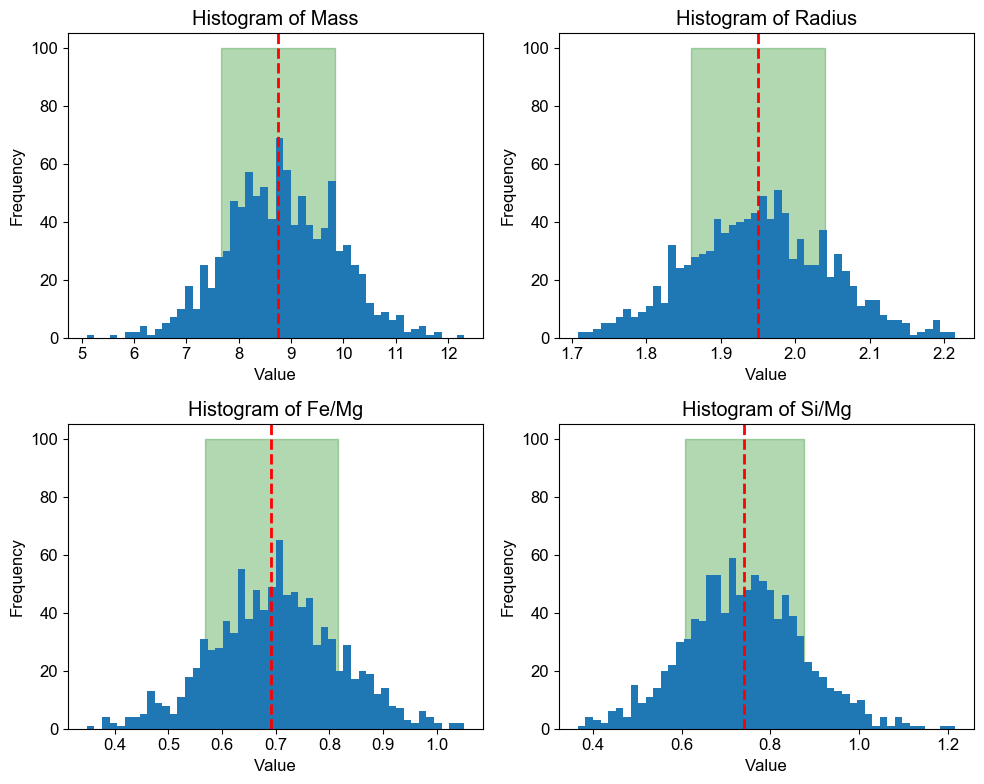

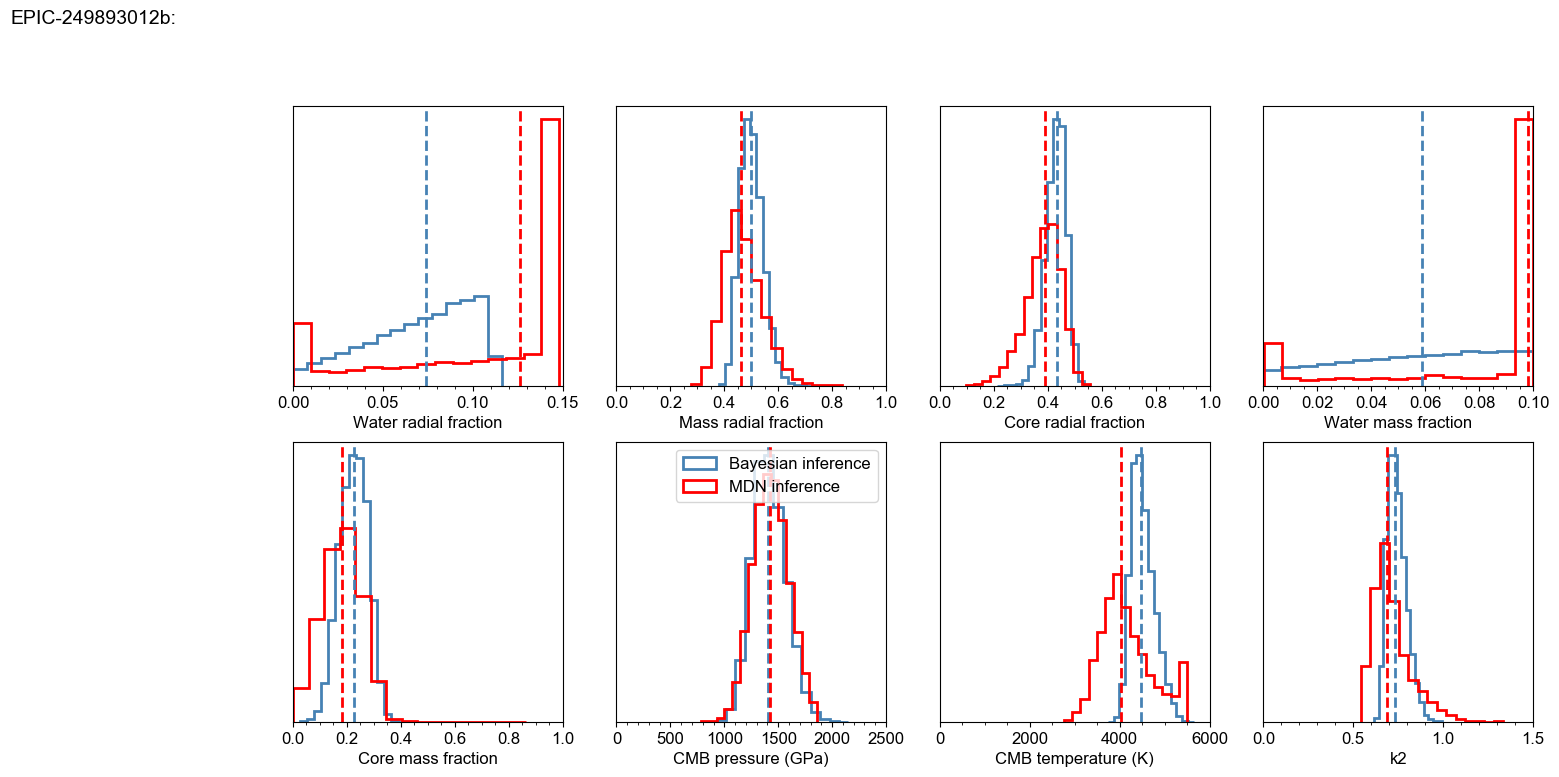

In [18]:
## Generate samples

# 设置随机数种子以便重复实验
np.random.seed(125)

# 从kepler 78b的均值和误差范围中生成1000个随机样本
mass_mean = 8.75
mass_err = 1.09
mass_samples = np.random.normal(loc=mass_mean, scale=mass_err, size=1000)

radius_mean = 1.95
radius_err = 0.09
radius_samples = np.random.normal(loc=radius_mean, scale=radius_err, size=1000)

femg_mean = 0.692
femg_err = 0.124
femg_samples = np.random.normal(loc=femg_mean, scale=femg_err, size=1000)

simg_mean = 0.741
simg_err = 0.134
simg_samples = np.random.normal(loc=simg_mean, scale=simg_err, size=1000)

# 将所有样本整合成一个输入矩阵
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# 创建一个2x2的子图画布
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 循环绘制每个子图中的直方图并标出均值和误差范围
for i, ax in enumerate(axs.flat):
    if i == 0:
        samples = mass_samples
        mean = mass_mean
        err = mass_err
        title = 'Histogram of Mass'
    elif i == 1:
        samples = radius_samples
        mean = radius_mean
        err = radius_err
        title = 'Histogram of Radius'
    elif i == 2:
        samples = femg_samples
        mean = femg_mean
        err = femg_err
        title = 'Histogram of Fe/Mg'
    else:
        samples = simg_samples
        mean = simg_mean
        err = simg_err
        title = 'Histogram of Si/Mg'

    ax.hist(samples, bins=50)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # 标出均值的竖直线
    ax.fill_between([mean-err, mean+err], [0,0], [100,100], alpha=0.3, color='green')  # 标出误差范围的区域

# 调整子图之间的距离和边界
plt.tight_layout()
plt.savefig('EPIC249893012b_gaussian_hist.pdf')
# 显示图表
plt.show()

## 叠加pdf

## Gaussian Sampling

input_list = X
density_x = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
density_y = {
    "WRF":[],  # H2O_radial_frac
    "MRF":[],  # Mantle_radial_frac
    "CRF":[],  # Core_radial_frac
    "WMF":[],
    "CMF":[],  # Core mass frac
    "CPS":[],  # CMB temperature
    "CTP":[],  # CMB pressure
    "k2":[] # k2
}
prop_density = [0, 0, 0, 0, 0, 0, 0, 0]  # 存储wrf,mrf,crf,cmf,cmb_t,cmb_p所有样本的概率分布加和
for input_array in input_list:
    scaled_input = input_scaler.transform([input_array])
#     print(1)
#     print(scaled_input)
    pred = model.predict(scaled_input)
    mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
    sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
    pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
    
    for m in range(OUTPUT_DIMS):
        locals()['mus'+str(m)] = []
        locals()['sigs'+str(m)] = []
    #     print(m)
        for n in range(N_MIXES):
    #         print(n)
            locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
            locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])
    y_label = np.arange(0,1,0.001).reshape(-1,1)
#     print(y_label)
    for i, output_param in enumerate(output_parameters):
#         ax = fig.add_subplot(3, 2, i+1)
        # y_label = y_labels[:, i].reshape(-1,1)
        # for i, label in zip(range(OUTPUT_DIMS), predict_label):
    #     fig, ax = plt.subplots(figsize=(8,4))
        # label = "Water radial fraction"
        ###################Earth###########################
        mus_ = np.array(locals()['mus'+str(i)])
#         print(mus_)
        sigs_ = np.array(locals()['sigs'+str(i)])
#         print(sigs_)
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
#         print(i)
#         print(GMM_PDF)
        pdf_nonzero = np.count_nonzero(GMM_PDF)
        if GMM_PDF.sum() ==0 or pdf_nonzero < 20:
            index = np.random.choice(y_label[:,0], size=20, replace=True)
        else:
#             size = min(20, pdf_nonzero)  # 确保采样大小不超过非零元素数量
            index = np.random.choice(y_label[:,0], size=20, replace=False, p=GMM_PDF/GMM_PDF.sum())
        bins = np.concatenate(([y_label[0, 0]], y_label[:, 0]))
        indices = np.searchsorted(bins, index) - 1
        density_x[output_param]=np.concatenate([density_x[output_param],y_label[:,0][indices]])
        density_y[output_param]=np.concatenate([density_y[output_param],GMM_PDF[indices]])



## MCMC vs MDN

x_max = [0.15,1, 1, 0.1, 1, 2500, 6000,1.5]
x_locator = [
    0.05,
    0.2,
    0.2,
    0.02,
    0.2,
    500,
    2000,
    0.5
]
colors = [
    "steelblue",
    "steelblue",
    "steelblue", 
    "steelblue", 
    "steelblue",
    "steelblue",
    "steelblue",
    "steelblue"
]
predict_label = [
    "Water radial fraction","Mass radial fraction", "Core radial fraction", 
    "Water mass fraction","Core mass fraction", "CMB pressure (GPa)", "CMB temperature (K)",
    "k2",
]


################# read mcmc results###############
file_path = "mcmc_results/EPIC249893012b_feo.csv"
df_k = pd.read_csv(file_path, 
#                    sep='\t'
                  )
df_k["MRF"] = 1 - df_k["WRF"] - df_k["CRF"]

################# transform mdn results to original data ###############
df_x = pd.DataFrame.from_dict(density_x)
original_x = output_scaler.inverse_transform(df_x)

################ plot histagram for predictions of MDN and MCMC ###################
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(
#     hspace=0.7, 
#     wspace=0.2
)
for i, output_param in enumerate(output_parameters):
    ax = fig.add_subplot(2, 4, i+1)
    
    # plot MCMC results
    x = df_k[output_param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='Bayesian inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = original_x[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)
#     label = f'Median: {median:.2f}'
#     ax.text(median, np.max(counts) / 2, label, ha='left', va='center', color='r', fontsize=12)
    
#     q16, q84 = np.percentile(params_x, [16, 84])
#     err_line = Line2D([q16, q84], [0.9 * np.max(hist), 0.9 * np.max(hist)], color='m', linewidth=2)
#     ax.add_line(err_line)
    
    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(predict_label[i])
    if i ==5:
        ax.legend()
fig.suptitle('EPIC-249893012b:', x=0, y=1, fontsize=14)
# fig.legend(["MCMC", "MDN"], loc='upper left', ncol=2)
# plt.tight_layout()
plt.savefig('EPIC249893012b.pdf')


df_k_p = df_k[output_parameters]
# 从MCMC结果中获取84%和16%的位置误差
q16 = df_k_p.quantile(0.16)
q84 = df_k_p.quantile(0.84)

# 计算MDN结果的中位数和位置误差
median = np.median(original_x, axis=0)
lower_err = median - np.percentile(original_x, q=16, axis=0)
upper_err = np.percentile(original_x, q=84, axis=0) - median

# 计算MCMC结果的中位数和位置误差
mcmc_median = df_k_p.median()
mcmc_lower_err = mcmc_median - q16
mcmc_upper_err = q84 - mcmc_median

# 将所有结果存储在一个DataFrame中
results = {
    "Output Parameter": predict_label,
    "MCMC Median": mcmc_median,
    "MDN Median": median.tolist(),
    "MCMC Lower Error": mcmc_lower_err,
    "MCMC Upper Error": mcmc_upper_err,
    "MDN Lower Error": lower_err,
    "MDN Upper Error": upper_err
}
df_results = pd.DataFrame(results)

# 将结果写入Excel文件
# df_results.to_excel("EPIC249893012b_err.xlsx", index=False)